# Clustering using Zillow Data

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np

# explore/ stat
import scipy.stats as stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D



# default pandas decimal display formatting
pd.options.display.float_format='{:20,.2f}'.format

# support modules
from env import host, user, password
import acquire
import summarize
import prepare
import explore


# model
from sklearn.cluster import KMeans

In [3]:
# acquire data, only retreive 261 > single residential family
# df = acquire.get_zillow_data().set_index("parcelid")

In [2]:
df = pd.read_csv('query_result.csv').set_index("parcelid")

In [3]:
# remove unit counts of two and three
df = df [(df.unitcnt != 2) | (df.unitcnt != 3)]

In [36]:
df.logerror.unique()

array([ 0.05561909,  0.0086689 ,  0.0576904 , ...,  0.02309215,
        0.17571199, -0.02022456])

In [37]:
df.taxvaluedollarcnt.describe()

count              44,749.00
mean              428,829.76
std               310,685.33
min                13,524.00
25%               201,098.00
50%               366,000.00
75%               571,105.00
max             2,090,230.00
Name: taxvaluedollarcnt, dtype: float64

In [12]:
summarize.df_summary(df)

--- Shape: (52169, 26)
--- Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52169 entries, 0 to 52168
Data columns (total 26 columns):
county                          52169 non-null object
tax_rate                        52164 non-null float64
parcelid                        52169 non-null int64
bathroomcnt                     52169 non-null float64
bedroomcnt                      52169 non-null int64
calculatedfinishedsquarefeet    52161 non-null float64
fips                            52169 non-null int64
latitude                        52169 non-null int64
longitude                       52169 non-null int64
lotsizesquarefeet               51815 non-null float64
propertycountylandusecode       52169 non-null object
rawcensustractandblock          52169 non-null float64
regionidcity                    51141 non-null float64
regionidcounty                  52169 non-null int64
regionidzip                     52146 non-null float64
roomcnt                         52169 non-null i

Los Angeles                         33752
Orange                              14061
Ventura                              4356
(-0.0017230000000000001, 0.0817]    52125
(0.0817, 0.163]                        30
(0.163, 0.245]                          3
(0.245, 0.327]                          2
(0.327, 0.408]                          1
(0.408, 0.49]                           1
(0.49, 0.572]                           1
(0.572, 0.653]                          0
(0.653, 0.735]                          0
(0.735, 0.816]                          1
(10554927.702, 26404584.7]          52152
(26404584.7, 42097314.4]                0
(42097314.4, 57790044.1]                0
(57790044.1, 73482773.8]                0
(73482773.8, 89175503.5]                1
(89175503.5, 104868233.2]               0
(104868233.2, 120560962.9]              0
(120560962.9, 136253692.6]              0
(136253692.6, 151946422.3]              0
(151946422.3, 167639152.0]             16
(0.982, 2.7]                      

**This function deals with missing values in the columns and the rows. If a row has more than 50% nulls, they will be removed. If a columns has more than 75% nulls, they will be removed.**

In [7]:
df = prepare.handle_missing_values(df, prop_required_column = .5, prop_required_row = .75)

After using this function, we didn't lose any rows, but we lost a lot of columns.

In [8]:
# summarize.report_remain_nulls_by_col(df, num_rows_of_interest)
summarize.report_remain_nulls_by_col(df, 200)

,num_rows_missing,pct_rows_missing
buildingqualitytypeid,18541,0.36
heatingorsystemtypeid,18345,0.35
heatingorsystemdesc,18345,0.35
lotsizesquarefeet,354,0.01
propertyzoningdesc,18479,0.35
regionidcity,1028,0.02
unitcnt,18451,0.35


In [9]:
# 1st feature construction
df['age'] = 2017 - df.yearbuilt

In [10]:
df = df.drop(columns = ['yearbuilt','propertylandusedesc','propertylandusetypeid','fullbathcnt','state','calculatedbathnbr','id','finishedsquarefeet12', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'heatingorsystemdesc', 'propertyzoningdesc', 'propertyzoningdesc', 'unitcnt'])
# now we can start impute and handle outlier

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a233bb390>,
      dtype=object)

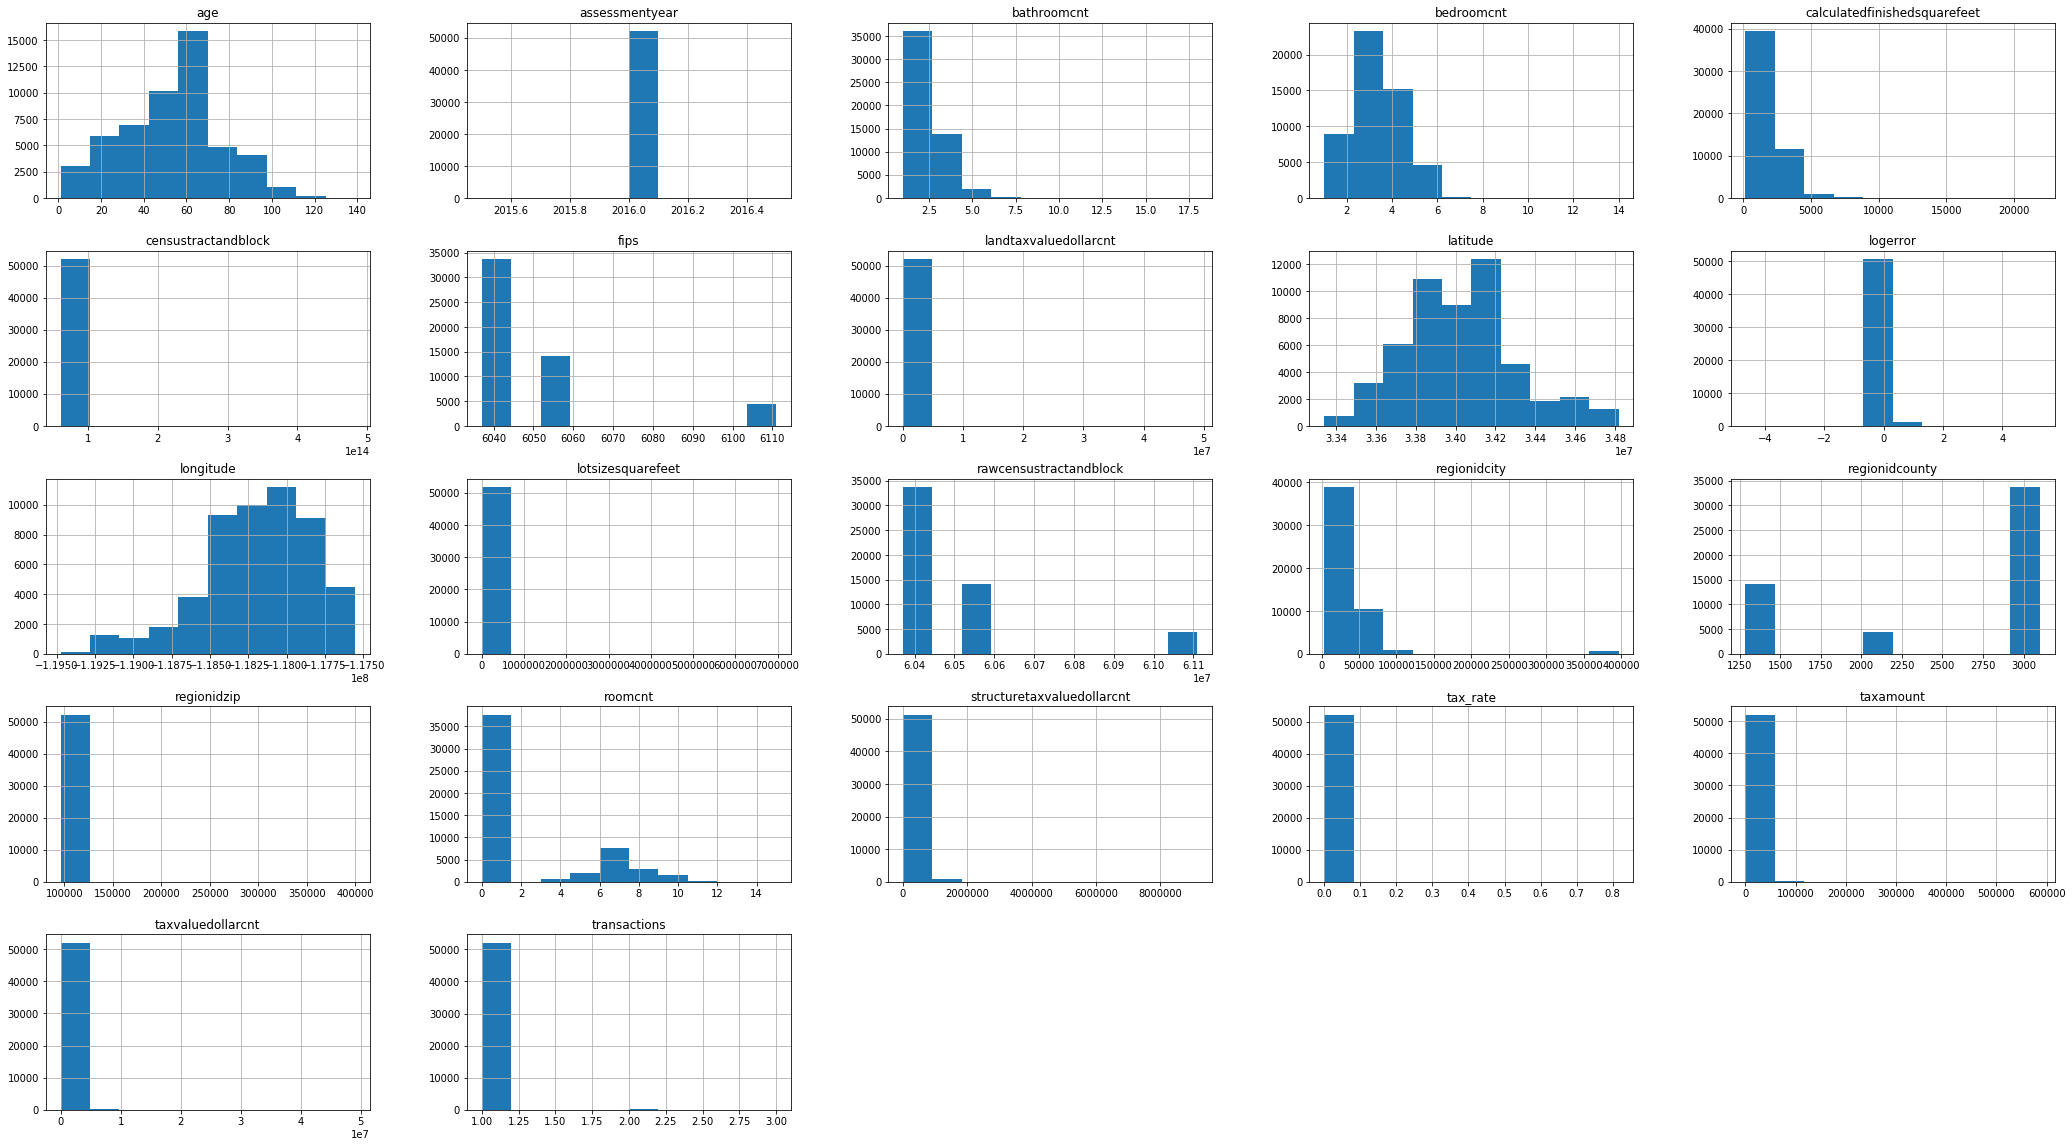

In [8]:
df.hist(figsize=(36,20))

In [14]:
# rm outlier
col_out = ["tax_rate", "bathroomcnt", "bedroomcnt","calculatedfinishedsquarefeet", "lotsizesquarefeet", "roomcnt", "taxamount"]
#df = prepare.remove_outliers_iqr(df, col_out)

In [15]:
def remove_outliers_iqr(df, col):

    q1, q3 = df[col].quantile([.25, .75])
    iqr = q3 - q1
    ub = q3 + 3 * iqr
    lb = q1 - 3 * iqr

    df = df[df[col] <= ub]
    df = df[df[col] >= lb]
    return df

In [16]:
df = remove_outliers_iqr(df, "tax_rate")
df = remove_outliers_iqr(df, "bathroomcnt")
df = remove_outliers_iqr(df, "bedroomcnt")
df = remove_outliers_iqr(df, "calculatedfinishedsquarefeet")
df = remove_outliers_iqr(df, "lotsizesquarefeet")
df = remove_outliers_iqr(df, "roomcnt")
df = remove_outliers_iqr(df, "taxamount")

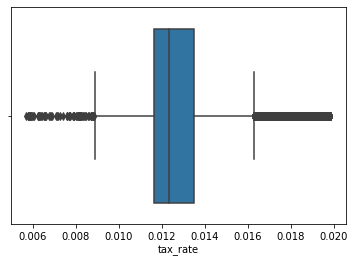

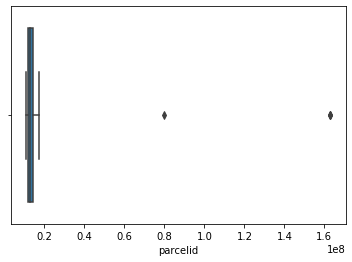

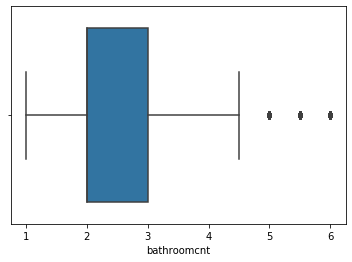

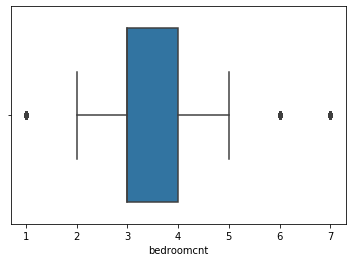

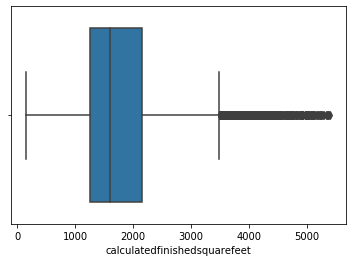

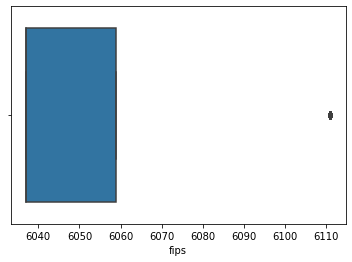

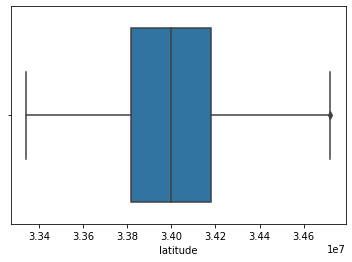

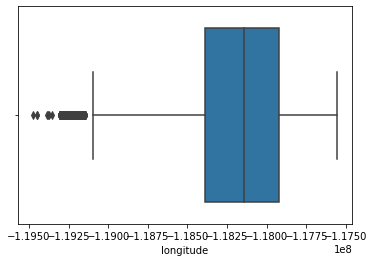

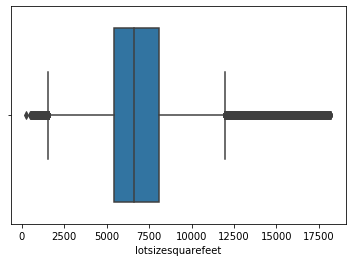

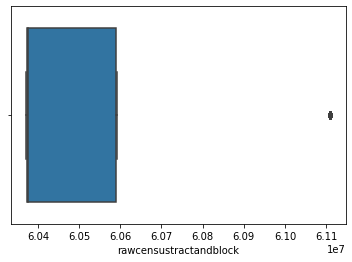

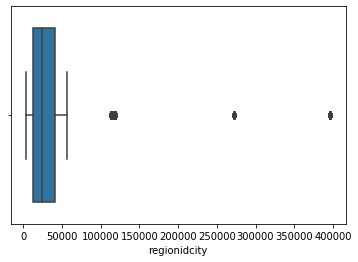

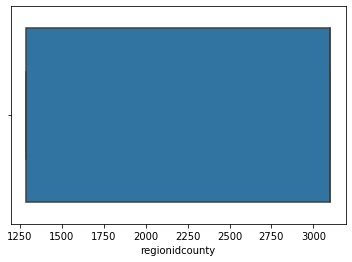

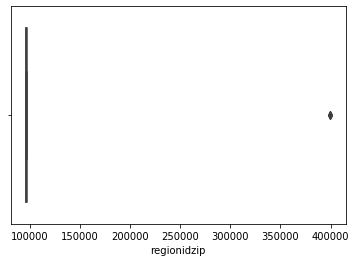

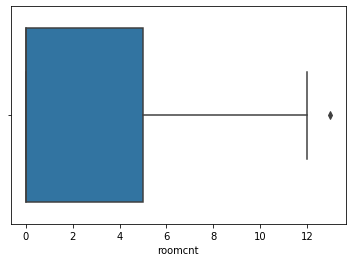

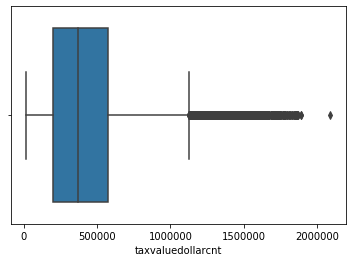

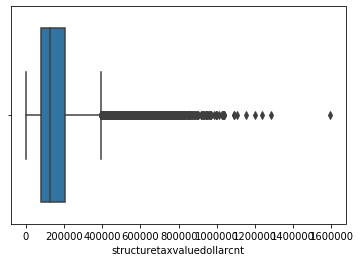

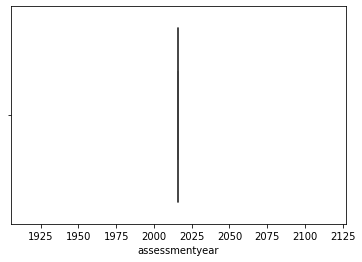

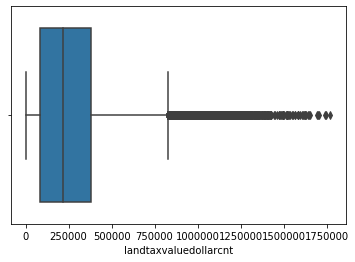

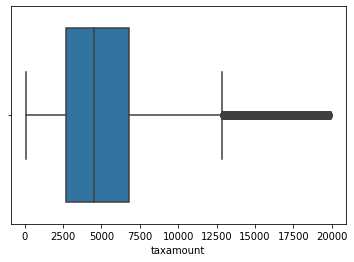

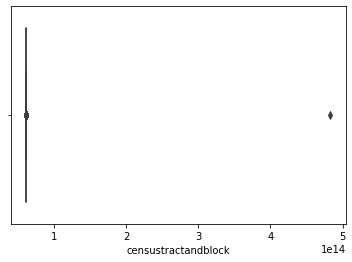

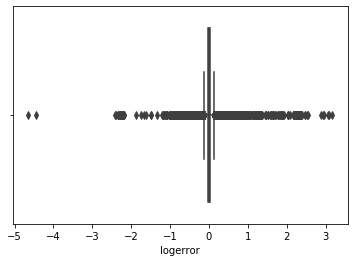

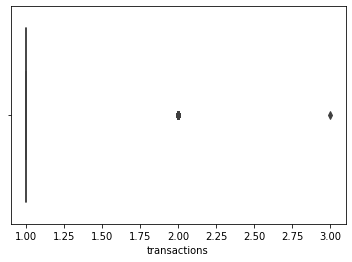

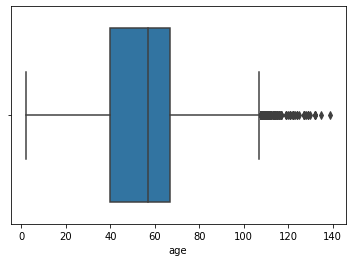

In [17]:
# validate outlier removal
# visualize the columns with boxplot
# identify outliers visually
explore.df_feature_box(df)

In [18]:
col_impute_mean = ['tax_rate', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 
                   'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

col_impute_mode = ['regionidcity', 'regionidzip','censustractandblock']

In [19]:
train, test = prepare.split_my_data(df)

In [15]:
train, test = prepare.impute(train, test, "mean", col_impute_mean)
train, test = prepare.impute(train, test, "most_frequent", col_impute_mode)

In [20]:
train["transactions"] = train.transactions.astype("float")

train["bedroomcnt"] = train.bedroomcnt.astype("int")
train["roomcnt"] = train.roomcnt.astype("int")

train["fips"] = train.fips.astype("object")
train["regionidcity"] = train.regionidcity.astype("object")
train["regionidcounty"] = train.regionidcounty.astype("object")
train["regionidzip"] = train.regionidzip.astype("object")
train["assessmentyear"] = train.assessmentyear.astype("object")


test["transactions"] = test.transactions.astype("float")

test["bedroomcnt"] = test.bedroomcnt.astype("int")
test["roomcnt"] = test.roomcnt.astype("int")

test["fips"] = test.fips.astype("object")
test["regionidcity"] = test.regionidcity.astype("object")
test["regionidcounty"] = test.regionidcounty.astype("object")
test["regionidzip"] = test.regionidzip.astype("object")
test["assessmentyear"] = test.assessmentyear.astype("object")

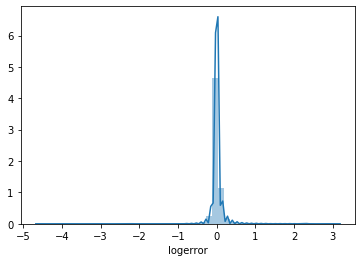

In [24]:
# overall logerror distribution 
sns.distplot(df.logerror)

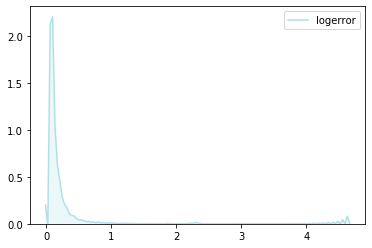

In [17]:
sns.kdeplot(df.logerror.abs(), shade=True, color="powderblue")
plt.show()

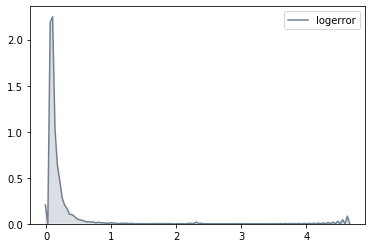

In [18]:
sns.kdeplot(train.logerror.abs(), shade=True, color="slategray")

Text(0, 0.5, 'inertia')

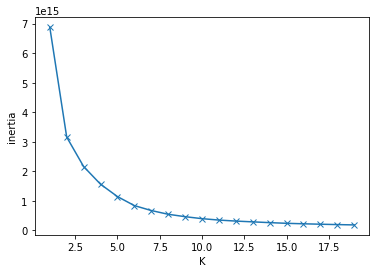

In [21]:
subset = train[['longitude', 'latitude','logerror']]

k_values = []
inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(subset)
    inertias.append(kmeans.inertia_)
    k_values.append(k)

plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('inertia')

In [22]:
subset = train[['longitude', 'latitude','logerror']]
kmeans = KMeans(n_clusters=7).fit(subset)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=subset.columns)

[Text(0.5, 0, 'Logerror'), Text(0.5, 0, 'Latitude'), Text(0.5, 0, 'Logitude')]

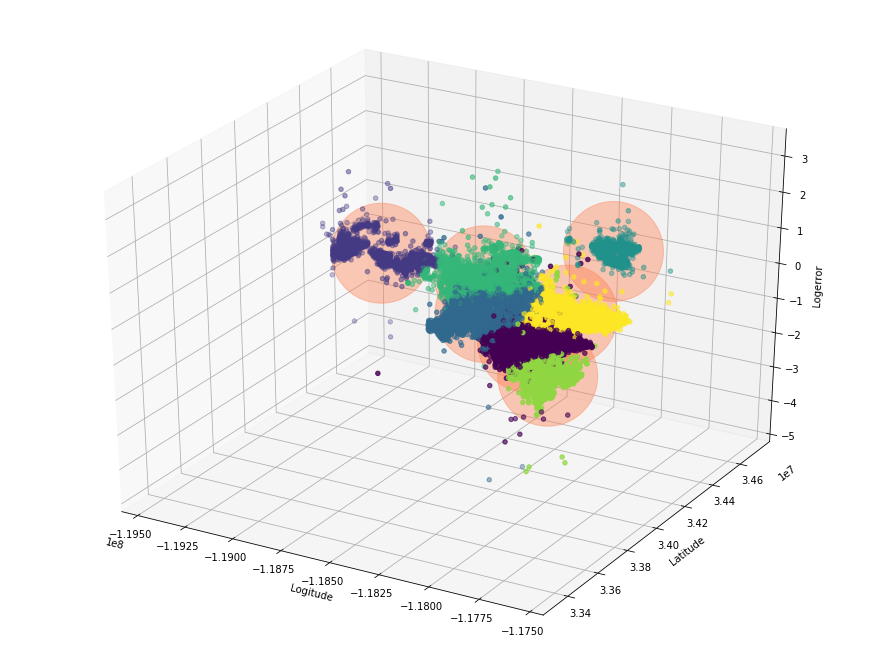

In [23]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, train.logerror, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.logerror, c='coral', s=10000, alpha=.4)
ax.set(xlabel='Logitude', ylabel='Latitude', zlabel='Logerror')

Text(0, 0.5, 'inertia')

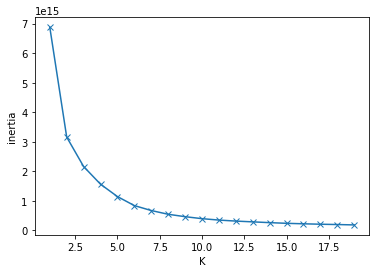

In [28]:
subset = train[['longitude', 'latitude','age']]

k_values = []
inertias = []

for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(subset)
    inertias.append(kmeans.inertia_)
    k_values.append(k)

plt.plot(k_values, inertias, marker='x')
plt.xlabel('K')
plt.ylabel('inertia')

[Text(0.5, 0, 'Age of House'),
 Text(0.5, 0, 'Latitude'),
 Text(0.5, 0, 'Logitude')]

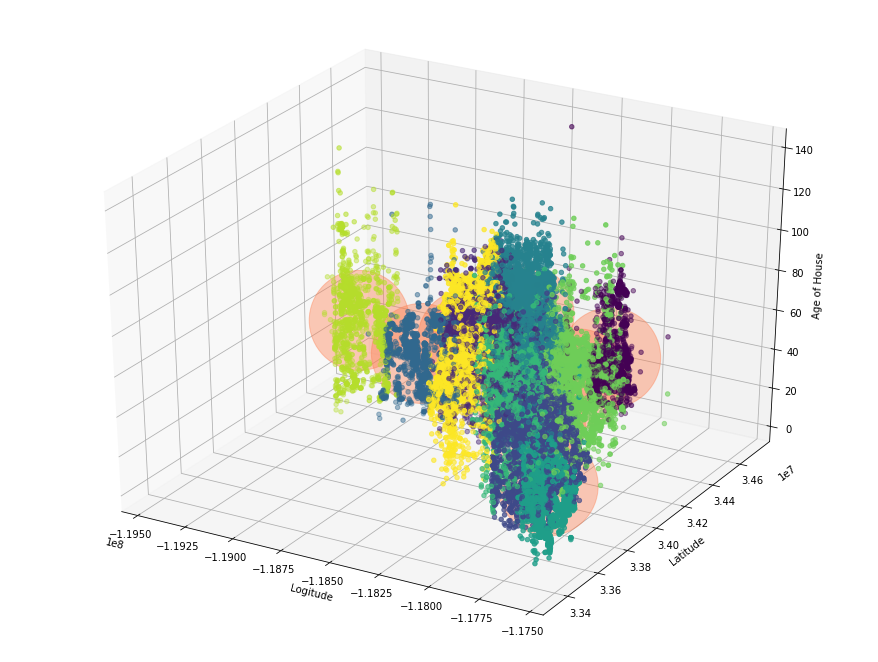

In [31]:
subset = train[['longitude', 'latitude','age']]
kmeans = KMeans(n_clusters= 10).fit(subset)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=subset.columns)
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(train.longitude, train.latitude, train.age, c=kmeans.labels_)
ax.scatter(centers.longitude, centers.latitude, centers.age, c='coral', s=10000, alpha=.4)
ax.set(xlabel='Logitude', ylabel='Latitude', zlabel='Age of House')

In [ ]:
def df_feature_dist(data):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.jointplot(feature, "logerror", data=data, kind="hex")
        plt.show()

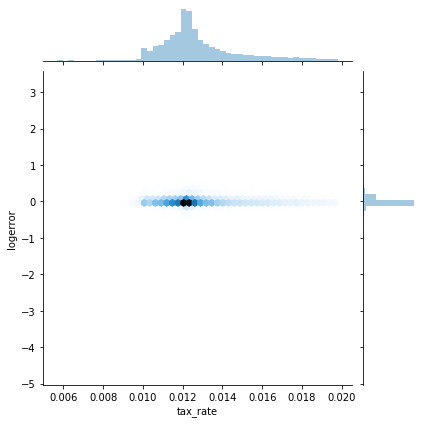

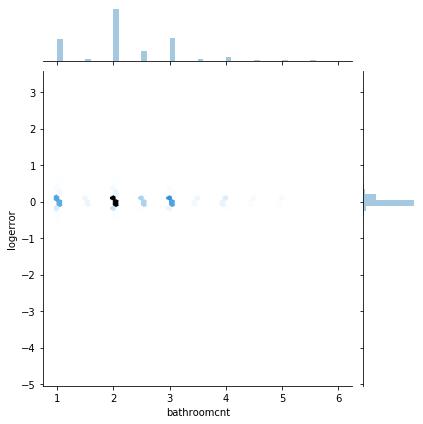

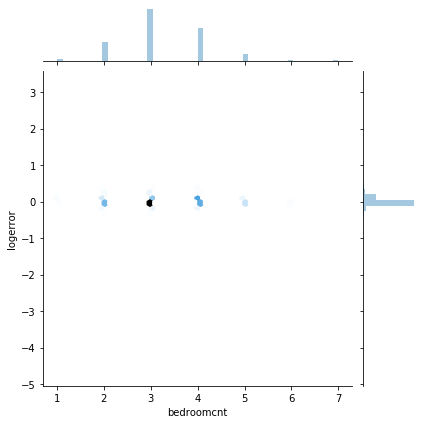

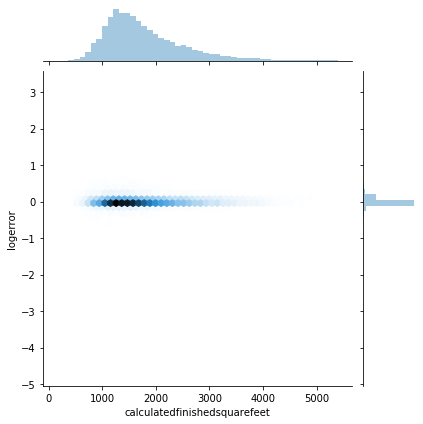

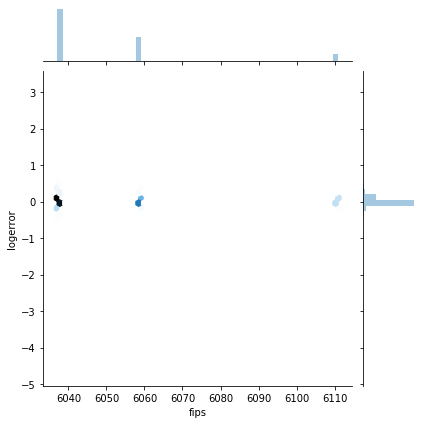

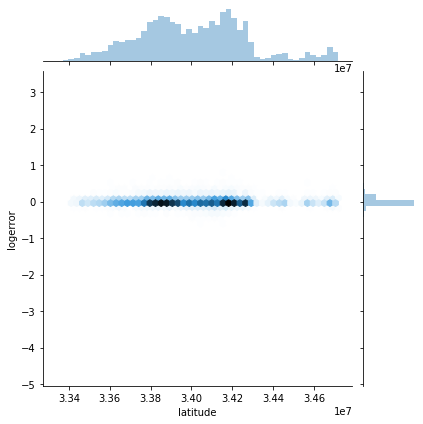

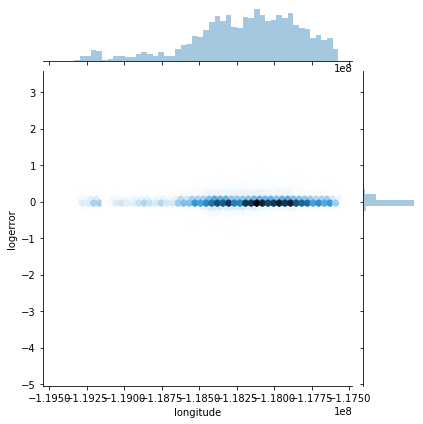

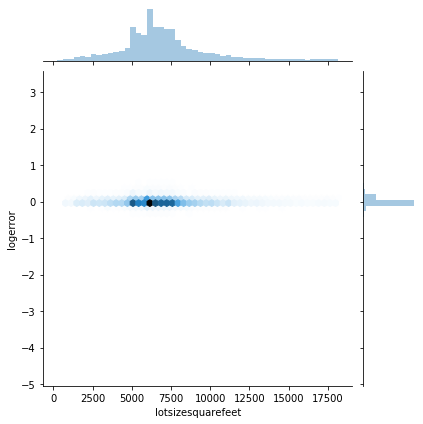

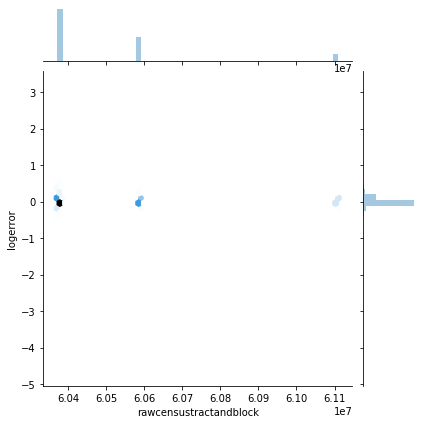

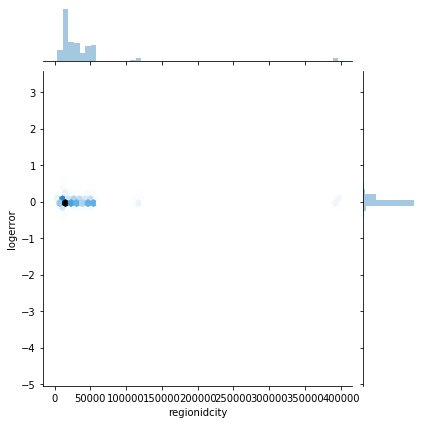

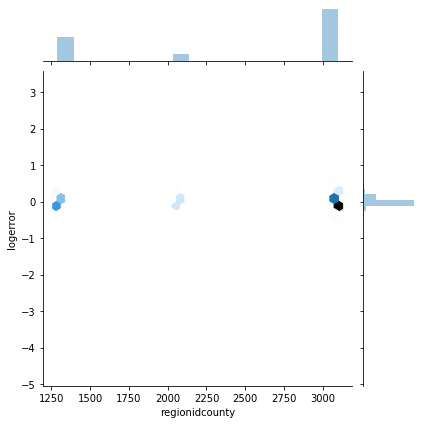

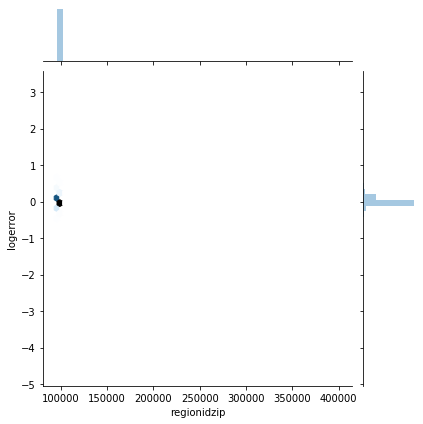

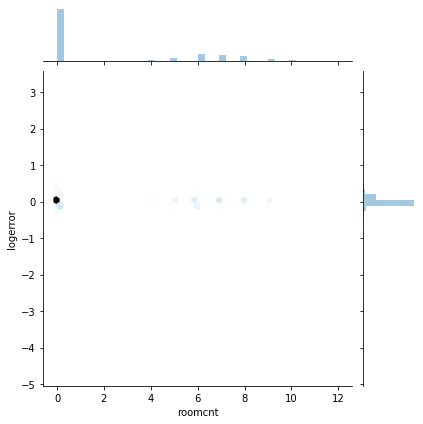

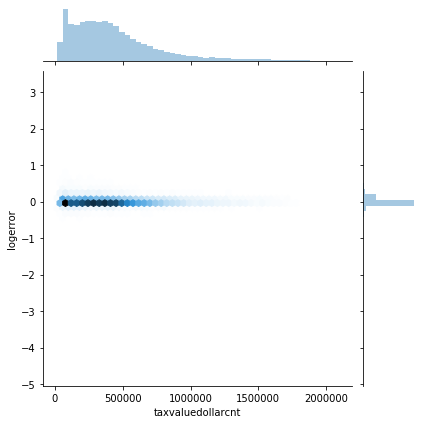

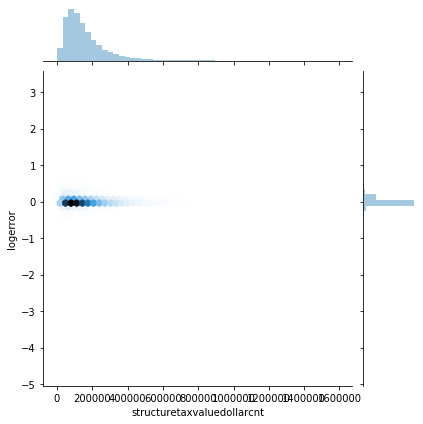

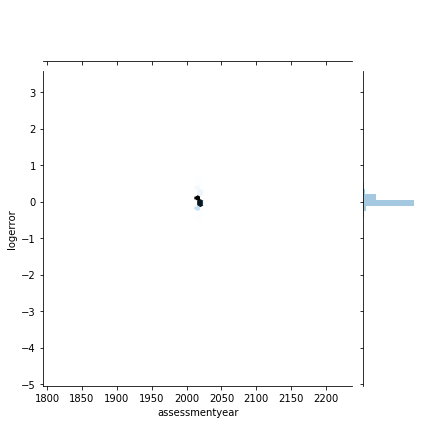

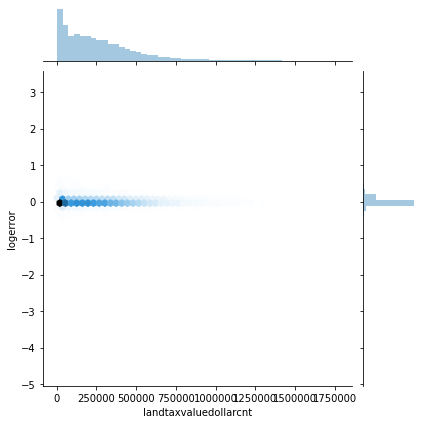

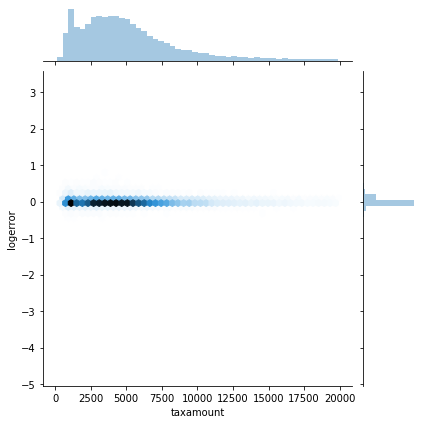

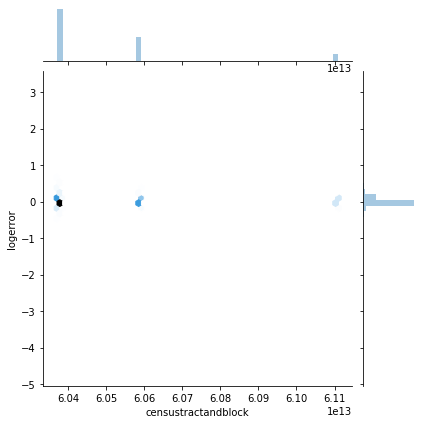

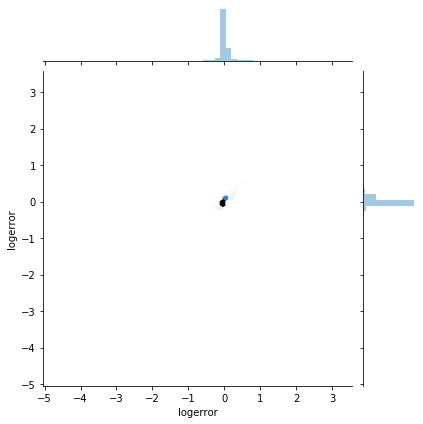

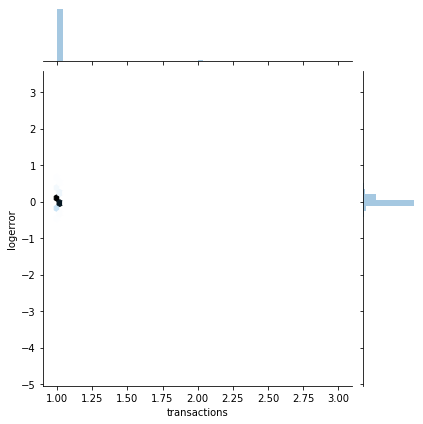

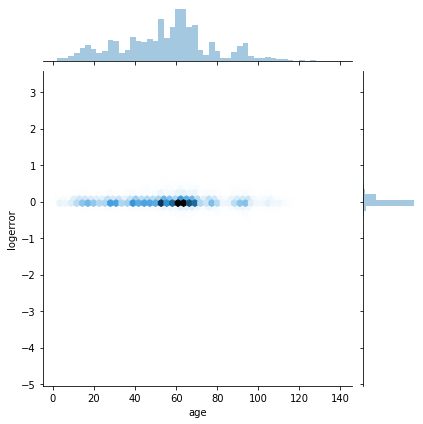

In [22]:
df_feature_dist(train)

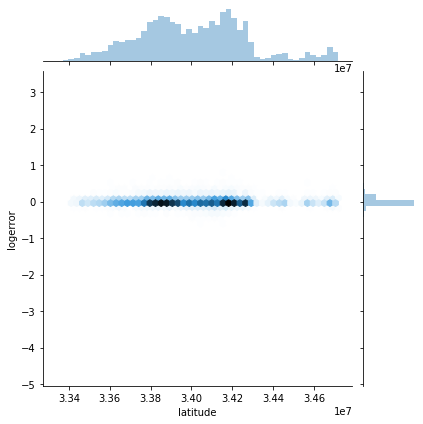

In [43]:
sns.jointplot("latitude", "logerror", data=train, kind="hex")

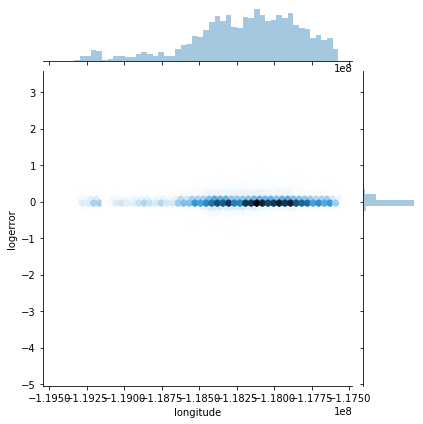

In [44]:
sns.jointplot("longitude", "logerror", data=train, kind="hex")

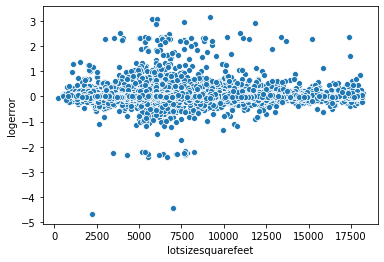

In [26]:
sns.scatterplot(x = 'lotsizesquarefeet', y = 'logerror', data=train, palette="Blues_d")

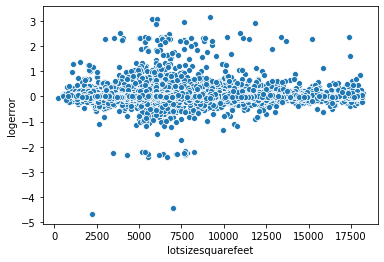

In [27]:
sns.scatterplot(x = 'lotsizesquarefeet', y = 'logerror', data=train, palette="Blues_d")

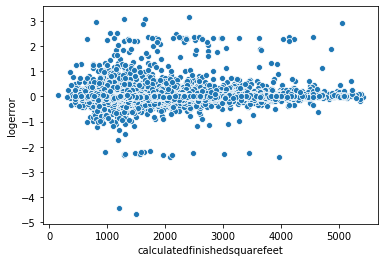

In [41]:
# ridge regression???
sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'logerror', data=train, palette="Blues_d")

In [35]:
# so many cities in the three counties!!!
train.regionidcity.nunique()

172

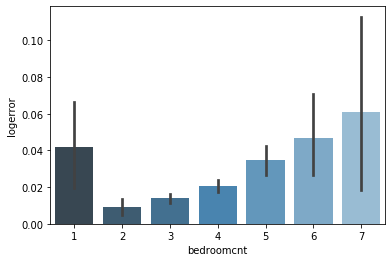

In [39]:
sns.barplot(x= 'bedroomcnt', y="logerror", data=train, palette="Blues_d")

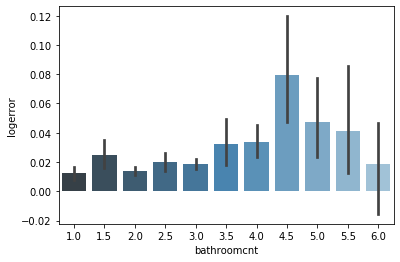

In [38]:
sns.barplot(x= 'bathroomcnt', y="logerror", data=train, palette="Blues_d")

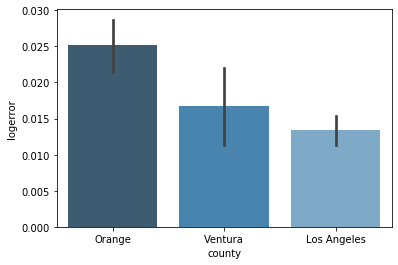

In [30]:
sns.barplot(x= 'county', y="logerror", data=train, palette="Blues_d")

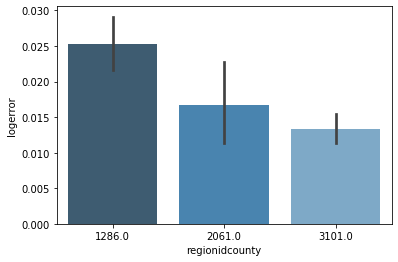

In [37]:
# can delete riogionidcounty
sns.barplot(x= 'regionidcounty', y="logerror", data=train, palette="Blues_d")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

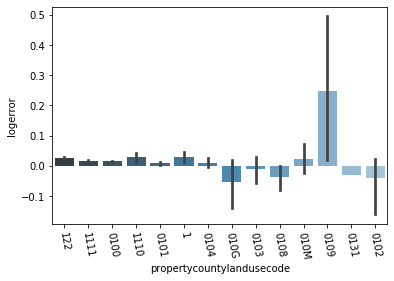

In [33]:
sns.barplot(x= 'propertycountylandusecode', y="logerror", data=train, palette="Blues_d")
plt.xticks(rotation=-80)

In [ ]:
# 'transactiondate','regionidzip', 'regionidcity' can't be object

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

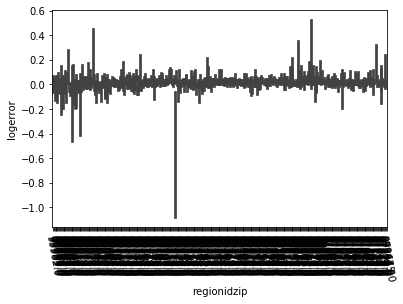

In [36]:
sns.barplot(x= 'regionidzip', y="logerror", data=train, palette="Blues_d")
plt.xticks(rotation=-80)

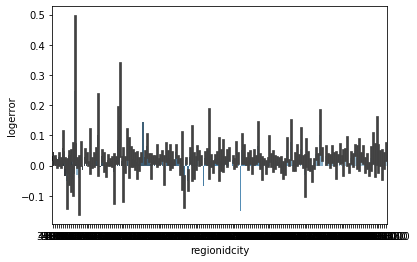

In [29]:
sns.barplot(x= 'regionidcity', y="logerror", data=train, palette="Blues_d")

The 'heatingorsystemtypeid', 'heatingorsystemdesc' and 'propertyzoningdesc' have significantly less values than the other values, but not so much so that they were removed with the function. We will just take note of this if we need to reference that leter on.

In [30]:
def df_feature_dist(df):
    # get a list of columns where content is number
    features_num = list(df.select_dtypes(np.number).columns)
    for feature in features_num:
        sns.distplot(df[feature].dropna())
        plt.show()

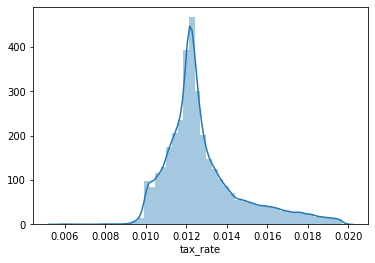

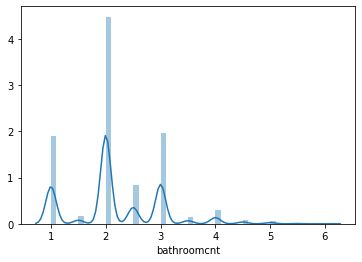

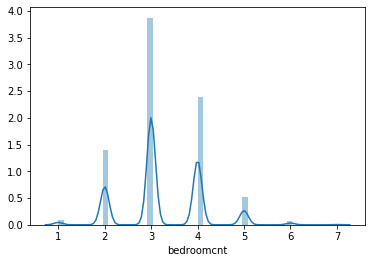

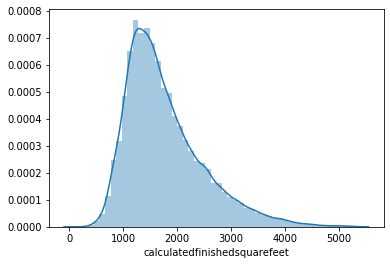

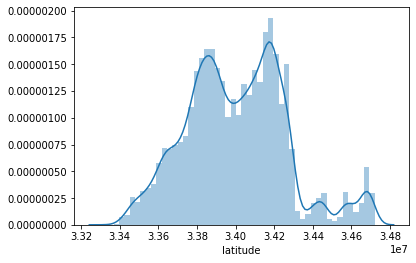

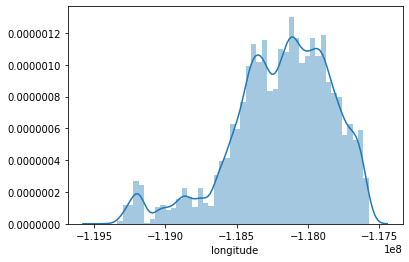

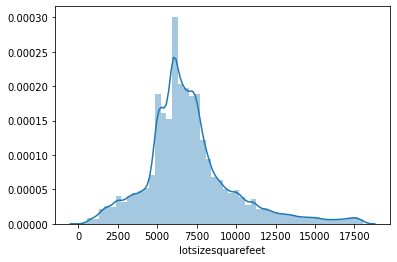

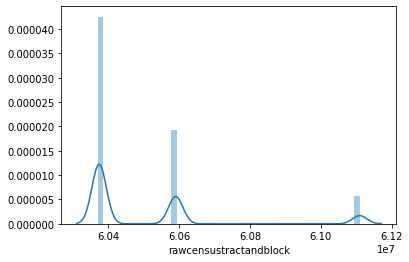

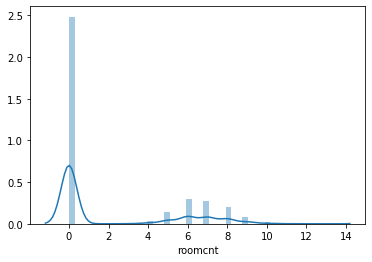

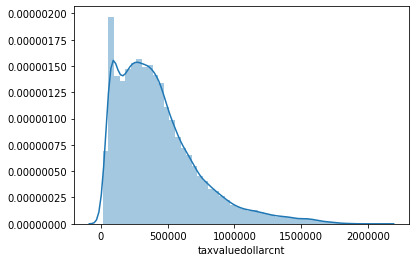

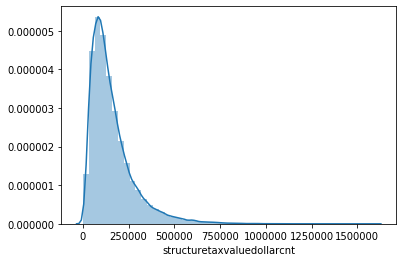

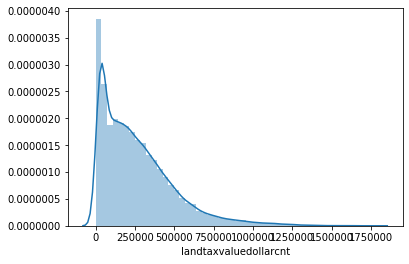

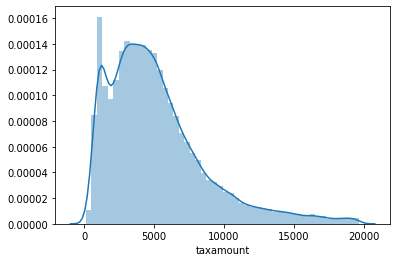

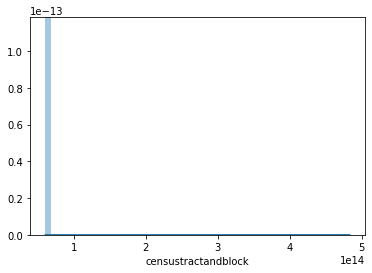

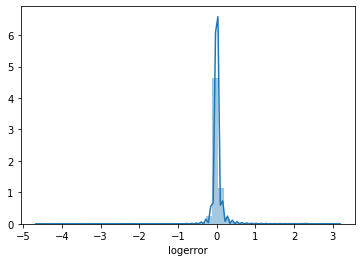

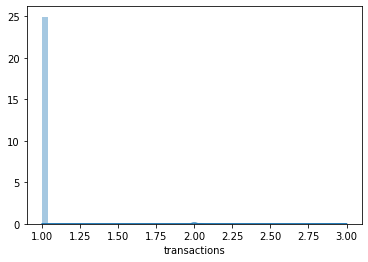

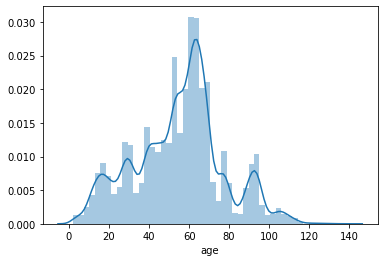

In [31]:
df_feature_dist(df)

**NOTES ABOUT FEATURES**
- calculatedfinishedsquarefeet max = 5408 seems really big
    think twice about what does calculatedfinishedsquarefeet truly means
    
    
- lotsizesquarefeet also really big, how does that compare to calc finished?

- roomcnt, bathroomcnt, bedroomcnt

- latitude and longitude need to be processed (make normal by /10^6?)

- rawcensustractandblock, censustractandblock, regionidcity, regionidcounty , regionidzip
    how to use? what value do these col bring?

- taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount

- assessmentyear > double check year

- age

- transactions???

- logerror > TARGET

**Understand Zestimate**
To calculate a Zestimate, Zillow uses a sophisticated and proprietary algorithm that incorporates data from county and tax assessor records and direct feeds from hundreds of multiple listing services and brokerages. The Zestimate also incorporates a home's facts and features, which homeowners have the ability to update.

The Zestimate accounts for variables like:

Home characteristics including square footage, location or the number of bathrooms
Unique features like hardwood floors, granite countertops or a landscaped backyard
On-market data such as listing price, description, comparable homes in the area and days on the market
Off-market data — tax assessments, prior sales and other publicly available records

In [43]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.describe())

                  tax_rate          bathroomcnt           bedroomcnt  \
count            44,749.00            44,749.00            44,749.00   
mean                  0.01                 2.19                 3.25   
std                   0.00                 0.84                 0.88   
min                   0.01                 1.00                 1.00   
25%                   0.01                 2.00                 3.00   
50%                   0.01                 2.00                 3.00   
75%                   0.01                 3.00                 4.00   
max                   0.02                 6.00                 7.00   

       calculatedfinishedsquarefeet                 fips             latitude  \
count                     44,749.00            44,749.00            44,749.00   
mean                       1,781.28             6,049.53        34,004,913.39   
std                          729.39                21.01           263,544.46   
min                        

Explore phase

In [ ]:
# single violin plot
fig = plt.figure(figsize=(5,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('Monthly_or_not', 'monthly_charges', hue='churn', data=train, split=True, palette="Dark2", ax = ax1)
plt.title('Relationship among Churn Rate, Contract Type & Monthly Charge')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# name_of_plot.fig.savefig(figure_output_path) 

In [ ]:
# multiple plot
features = ['gender', 'partner', 'dependents', 'multiple_lines']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Churn rates based on features')


features = ['device_protection', 'tech_support', 'paperless_billing', 'internet_service_type']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    
features = ['contract_type', 'payment_type']
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-80)
plt.show()

In [ ]:
# cat & cat
for i in train.drop(columns='churn'):
    sns.barplot(x=i, y='churn', data=train, color='Blue')
    plt.show()

sns.barplot(x="prod_phone_service", y="monthly_charges",data=train_red,hue="churn")
plt.legend()
plt.hlines(y=train_red.monthly_charges.mean(), xmin=-1, xmax=3, ls=":")


# categorical & continuous
sns.swarmplot(x="online_security_backup", y="monthly_charges", data=train_df, hue="churn", palette="Set2")
ax = sns.boxplot(x="online_security_backup", y="monthly_charges", data=train_df,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})